<img src='http://acornpub.co.kr/tb/detail/book/af/gq/1630605102hbvP2J7K.jpg' />

[에이콘 출판사 TLS 구현으로 배우는 암호학](http://acornpub.co.kr/book/tls-cryptography)

C++에 대해 언어의 장벽을 느끼는 분들을 위해 1편. 암호학의 기초와 2편의 인증서 부분의 이해를 돕기 위해 Python으로 코드들을 만들어 보았습니다.
인증서를 추출하기 위해 DER을 파싱하는 부분은 많이 간략화하여 공개키와 서명을 뽑아내는 기능만을 하도록 하였고, 그 외의 부분은 동일한 기능을 하는 소스입니다. 단, CBC, GCM 등 AES cipher mode와 HMAC은 다루지 않았습니다. RSA 인증서 체인 확인하는 소스는 RSA의 뒤로 옮겼습니다. 암호학의 이해에 조금이라도 더 도움이 되었으면 좋겠습니다.

# 왜 암호학인가?
암호학은 컴퓨터 문명의 지반에 깊숙히 자리하고 있다. 
자신의 아이디와 패스워드를 입력할 때 뿐만이 아니라, 
우리가 앱을 이용해 돈을 이체할 때에도
웹사이트를 서핑할 때에도 암호학은 이용된다.
자신이 프로그래머라면 이러한 기능들을 몇 번씩은 구현해 보았을 것이다. 
그러나, 그 기능들의 기반에 대한 명확한 지식이 없이 프로그램을 만들었을 때, 
api를 이용하여 완벽하게 구현했음에도 본인 스스로 미진한 점을 느끼기도 하고,
드문 경우에는 프로그램에 헛점을 만들기도 한다.

현대에 프로그래머는 대략 두 종류로 나누어 볼 수 있다.
- 자신의 전문분야가 있고, 그 분야의 업무에 프로그래밍을 접목하여 사용하는 사람.(데이터분석가, 과학자 등등)
- 프로그래밍을 전문적으로 하는 사람. 즉, 프로그램을 구조적으로 잘 짜는 법에 대해 정통한 사람

자신이 만약 두번째 범주에 해당된다면, 암호학은 프로그래머로서는 반드시 넘어야 할 산이다.
물론 암호학의 전문적인 지식을 모두 습득해야 하는 것은 아니다.
하지만, 암호학이 어떤 식으로 작동하고 있는지에
대해 단순한 개념적인 차원에서 그치지 않는 실질적인 지식을 가지고 있어야 한다.
이는 사실 그렇게 어렵지 않다.

# 왜 TLS인가?
TLS는 Transport Layer Security의 약자로 네트워크 통신상에서 상대방과 안전하게 통신을 하기 위한 통신규약이다. 
https://로 시작되는 인터넷 주소도 TLS위에서 작동한다.
TLS는 한마디로 현대암호학을 총망라하여 가장 실용적으로 적용시켜 가장 광범위하게 사용되는 예라고 할 수 있다.
TLS의 작동 기전을 이해하면, 암호학이 다루는 각 분야의 의미와 필요성을 이해할 수 있을 것이다.

# Caesar's Cipher

In [46]:
def caesar_encode(message, key):#코드 2
    r = ''
    for c in message: r += chr(ord(c) + key)
    return r

def caesar_decode(message, key):
    r = ''
    for c in message: r += chr(ord(c) - key)
    return r

m = "Caesar's cipher test"
m = caesar_encode(m, 3)
print(m)
m = caesar_decode(m, 3)
print(m)

Fdhvdu*v#flskhu#whvw
Caesar's cipher test


# Diffie Hellman

In [13]:
def powm(base, exp, mod):# 코드 1.1
    r = 1
    for i in range(exp):
        r *= base
        r %= mod
        if i >= exp: break
    return r

powm(3, 31, 29)

27

In [14]:
def is_primitive(base, mod):# 코드 1.2
    exp = 2
    r = base * base
    while r != base:
        r *= base
        r %= mod
        exp += 1
    return exp == mod

def primitive_root(mod):#mod 는 소수이어야 함.
    v = []
    for base in range(2, mod):
        if is_primitive(base, mod): v.append(base)
    return v

primitive_root(29)

[2, 3, 8, 10, 11, 14, 15, 18, 19, 21, 26, 27]

In [15]:
import os, binascii
from gmpy2 import mpz, next_prime, mpz_urandomb, random_state, powmod

print(os.urandom(32))
print(binascii.hexlify(os.urandom(32)))
print(int(binascii.hexlify(os.urandom(32)), 16))

def random_prime(byte_length):
    seed = int(binascii.hexlify(os.urandom(32)), 16)
    rand = random_state(seed)
    z = mpz_urandomb(rand, byte_length * 8)
    return next_prime(z)

b'\xf4 \xb8}\xa4\xd0#\xa9\t\xc4\xea;\x90\x86R\xdd\xbf*\xcb\xedv)?\x9eQ\xec\x8e\xa8\x01\xa7\xfaO'
b'c5ee6d3af1c6ff01d9f7d53efd2185bc5b066fa075721fb123c1d58667789fc6'
4537720313425641845472899669945239965258395907364444457122119008387437912606


In [16]:
class DiffieHellman:#코드 1.5
    def __init__(self):
        self.x = random_prime(255)
        self.y = powmod(self.g, self.x, self.p)
    p = 0xFFFFFFFFFFFFFFFFADF85458A2BB4A9AAFDC5620273D3CF1D8B9C583CE2D3695A9E13641146433FBCC939DCE249B3EF97D2FE363630C75D8F681B202AEC4617AD3DF1ED5D5FD65612433F51F5F066ED0856365553DED1AF3B557135E7F57C935984F0C70E0E68B77E2A689DAF3EFE8721DF158A136ADE73530ACCA4F483A797ABC0AB182B324FB61D108A94BB2C8E3FBB96ADAB760D7F4681D4F42A3DE394DF4AE56EDE76372BB190B07A7C8EE0A6D709E02FCE1CDF7E2ECC03404CD28342F619172FE9CE98583FF8E4F1232EEF28183C3FE3B1B4C6FAD733BB5FCBC2EC22005C58EF1837D1683B2C6F34A26C1B2EFFA886B423861285C97FFFFFFFFFFFFFFFF
    g = 2
    def set_peer_pubkey(self, pub_key):
        self.K = powmod(pub_key, self.x, DiffieHellman.p)
        return self.K

In [17]:
Alice = DiffieHellman() # 코드 1.6
Bob = DiffieHellman()
Alice.set_peer_pubkey(Bob.y)
Bob.set_peer_pubkey(Alice.y)
print(Alice.K)
print(Bob.K)

30807967527578306122747518079695873649485767588777152881320804823351706065004976431337370918418095879583456481971693576148169085881119754261895564393053248760418714918419969227673989582245475713024890181150197693713622292146857683193988705269033818127249331779533038838444337162209210460057898475370047717456546303029164380937466676160274352325490048767820496203680067162601628148374922720352465382928731729279681400668638073127758332427667149958068553651223702550807798629953133068430332931827687205046816915153765560608890864014579063317210241383622537771410006592206279236756512476857233074077183387684235937642183
3080796752757830612274751807969587364948576758877715288132080482335170606500497643133737091841809587958345648197169357614816908588111975426189556439305324876041871491841996922767398958224547571302489018115019769371362229214685768319398870526903381812724933177953303883844433716220921046005789847537004771745654630302916438093746667616027435232549004876782049620368006716260162814837

# Elliptic Curve

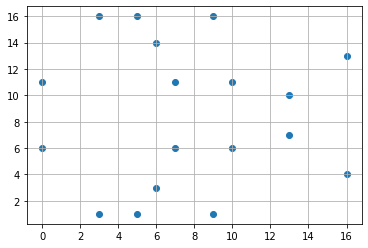

In [18]:
import matplotlib.pyplot as plt

X = []
Y = []

for x in range(17):
    for y in range(17):
        if (x**3 + 2*x + 2 - y**2) % 17 == 0:
            X.append(x)
            Y.append(y)

plt.grid()
plt.scatter(X,Y)
plt.show()

In [19]:
import gmpy2 # 코드 1.9 ~ 1.10
class EC_Field:
    def __init__(self, a, b, mod):
        self.a = a
        self.b = b
        self.mod = mod
    def mod_inv(self, z):
        return gmpy2.invert(z, self.mod)
class EC_Point(EC_Field):
    def __init__(self, x, y, field):
        super().__init__(field.a, field.b, field.mod)
        self.x = mpz(x)
        self.y = mpz(y)
    def __eq__(self, r):
        return self.x == r.x and self.y == r.y
    def __add__(self, r):
        if r.y == self.mod: return self
        if self.y == self.mod: return r
        if r == self: 
            if self.y == 0: return EC_Point(self.x, self.mod, self)
            self.s = (3 * self.x * self.x + self.a) * super().mod_inv(2 * self.y) % self.mod
        else:
            if self.x == r.x: return EC_Point(self.x, self.mod, self)
            self.s = (r.y - self.y) * self.mod_inv(r.x - self.x) % self.mod
        x3 = (self.s * self.s - self.x - r.x) % self.mod
        y3 = (self.s * (self.x - x3) - self.y) % self.mod
        return EC_Point(x3, y3, self)
    def __mul__(self, r):
        bits = []
        while r > 0:
            bits.append(r % 2 == 1)
            r = r // 2
        X = self
        R = EC_Point(0, self.mod, self)
        for a in bits:
            if a: R = R + X
            X = X + X
        return R
    __rmul__ = __mul__
    __lmul__ = __mul__
    def __str__(self):
        return '(' + self.x.digits(16) + ', ' + self.y.digits(16) + ')'

In [20]:
secp256k1 = EC_Field(0, 7, mpz('0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEFFFFFC2F'))#코드 1.11
G = EC_Point(mpz('0x79BE667EF9DCBBAC55A06295CE870B07029BFCDB2DCE28D959F2815B16F81798'),
	mpz('0x483ADA7726A3C4655DA4FBFC0E1108A8FD17B448A68554199C47D08FFB10D4B8'), secp256k1)
for i in range(1,5): print(i*G)

(79be667ef9dcbbac55a06295ce870b07029bfcdb2dce28d959f2815b16f81798, 483ada7726a3c4655da4fbfc0e1108a8fd17b448a68554199c47d08ffb10d4b8)
(c6047f9441ed7d6d3045406e95c07cd85c778e4b8cef3ca7abac09b95c709ee5, 1ae168fea63dc339a3c58419466ceaeef7f632653266d0e1236431a950cfe52a)
(f9308a019258c31049344f85f89d5229b531c845836f99b08601f113bce036f9, 388f7b0f632de8140fe337e62a37f3566500a99934c2231b6cb9fd7584b8e672)
(e493dbf1c10d80f3581e4904930b1404cc6c13900ee0758474fa94abe8c4cd13, 51ed993ea0d455b75642e2098ea51448d967ae33bfbdfe40cfe97bdc47739922)


In [21]:
field = EC_Field(2, 2, 17) # 코드 1.12
P = EC_Point(5, 1, field)
for i in range(1, 20): print(i * P)
xA = P * 3
xB = P * 7
KA = xB * 3
KB = xA * 7
print(xA, xB, KA, KB)

(5, 1)
(6, 3)
(a, 6)
(3, 1)
(9, 10)
(10, d)
(0, 6)
(d, 7)
(7, 6)
(7, b)
(d, a)
(0, b)
(10, 4)
(9, 1)
(3, 10)
(a, b)
(6, e)
(5, 10)
(a, 11)
(a, 6) (0, 6) (6, 3) (6, 3)


# 인증

In [22]:
class RSA:# 코드 2.1
    def __init__(self, key_size = None):
        if key_size is None: return
        self.p = random_prime(key_size // 2)
        self.q = random_prime(key_size // 2)
        self.K = self.p * self.q
        self.phi = gmpy2.lcm(self.p - 1, self.q - 1)
        self.e = 0x1001
        while gmpy2.gcd(self.e, self.phi) != 1:
            self.e = gmpy2.next_prime(self.e)
        self.d = gmpy2.invert(self.e, self.phi)
    def set(self, e, d, K):
        self.e = e
        self.d = d
        self.K = K
    def encode(self, m): return gmpy2.powmod(m, self.e, self.K)
    def decode(self, m): return gmpy2.powmod(m, self.d, self.K)
    def sign(self, m): return self.decode(m)

In [23]:
rsa = RSA(256) # 코드 2.2
a = rsa.encode(mpz('0x23423423'))
print(rsa.decode(a).digits(16))
msg = 0x143214324234
b = rsa.sign(msg)
print(rsa.encode(b).digits(16))

23423423
143214324234


In [24]:
class ECDSA(EC_Point): # 코드 2.3 ~ 2.4
    def __init__(self, G, n):
        super().__init__(G.x, G.y, G)
        self.n = n
        self.nbit = n.bit_length()
        self.G = G
    def mod_inv(self, z):
        return gmpy2.invert(z, self.n)
    def sign(self, msg, d):
        mBit = msg.bit_length()
        z = msg >> max(mBit - self.nbit, 0)
        k = mpz(0)
        s = mpz(0)
        r = mpz(0)
        while s == 0:
            while r == 0:
                k = random_prime(31) % self.n
                P = k * self.G
                r = P.x % self.n
            s = (self.mod_inv(k) * (z + r * d)) % self.n
        return (r, s)
    def verify(self, m, sig, Q):
        r, s = sig
        if r < 1 or r >= self.n: return False
        if s < 1 or s >= self.n: return False
        mBit = m.bit_length()
        z = m >> max(mBit - self.nbit, 0)
        u1 = z * self.mod_inv(s) % self.n
        u2 = r * self.mod_inv(s) % self.n
        P = u1 * self + u2 * Q
        if P.y == self.mod: return False
        if (P.x - r) % self.n == 0: return True
        else: return False

In [28]:
secp256r1 = EC_Field(mpz('0xFFFFFFFF00000001000000000000000000000000FFFFFFFFFFFFFFFFFFFFFFFC'), #코드 2.5
    mpz('0x5AC635D8AA3A93E7B3EBBD55769886BC651D06B0CC53B0F63BCE3C3E27D2604B'), 
    mpz('0xFFFFFFFF00000001000000000000000000000000FFFFFFFFFFFFFFFFFFFFFFFF'))
G = EC_Point(mpz('0x6B17D1F2E12C4247F8BCE6E563A440F277037D812DEB33A0F4A13945D898C296'),
    mpz('0x4FE342E2FE1A7F9B8EE7EB4A7C0F9E162BCE33576B315ECECBB6406837BF51F5'), secp256r1);
n = mpz('0xFFFFFFFF00000000FFFFFFFFFFFFFFFFBCE6FAADA7179E84F3B9CAC2FC632551')
d = mpz('0xfd8961b427cec83cfd443cbd98ca8084273d5d2d62e45b59fb106819b6abad')
Q = d * G

ecdsa = ECDSA(G, n)
signature = ecdsa.sign(0xff, d)
ecdsa.verify(0xff, signature, Q)

True

# 인증서

In [47]:
# 139page
server_cert_pem = '''
Certificate:
    Data:
        Version: 3 (0x2)
        Serial Number: 1 (0x1)
    Signature Algorithm: sha256WithRSAEncryption
        Issuer: C=US, ST=Montana, L=Bozeman, O=Sawtooth, OU=Consulting, CN=www.wolfssl.com/emailAddress=info@wolfssl.com
        Validity
            Not Before: Aug 11 20:07:37 2016 GMT
            Not After : May  8 20:07:37 2019 GMT
        Subject: C=US, ST=Montana, L=Bozeman, O=wolfSSL, OU=Support, CN=www.wolfssl.com/emailAddress=info@wolfssl.com
        Subject Public Key Info:
            Public Key Algorithm: rsaEncryption
                Public-Key: (2048 bit)
                Modulus:
                    00:c0:95:08:e1:57:41:f2:71:6d:b7:d2:45:41:27:
                    01:65:c6:45:ae:f2:bc:24:30:b8:95:ce:2f:4e:d6:
                    f6:1c:88:bc:7c:9f:fb:a8:67:7f:fe:5c:9c:51:75:
                    f7:8a:ca:07:e7:35:2f:8f:e1:bd:7b:c0:2f:7c:ab:
                    64:a8:17:fc:ca:5d:7b:ba:e0:21:e5:72:2e:6f:2e:
                    86:d8:95:73:da:ac:1b:53:b9:5f:3f:d7:19:0d:25:
                    4f:e1:63:63:51:8b:0b:64:3f:ad:43:b8:a5:1c:5c:
                    34:b3:ae:00:a0:63:c5:f6:7f:0b:59:68:78:73:a6:
                    8c:18:a9:02:6d:af:c3:19:01:2e:b8:10:e3:c6:cc:
                    40:b4:69:a3:46:33:69:87:6e:c4:bb:17:a6:f3:e8:
                    dd:ad:73:bc:7b:2f:21:b5:fd:66:51:0c:bd:54:b3:
                    e1:6d:5f:1c:bc:23:73:d1:09:03:89:14:d2:10:b9:
                    64:c3:2a:d0:a1:96:4a:bc:e1:d4:1a:5b:c7:a0:c0:
                    c1:63:78:0f:44:37:30:32:96:80:32:23:95:a1:77:
                    ba:13:d2:97:73:e2:5d:25:c9:6a:0d:c3:39:60:a4:
                    b4:b0:69:42:42:09:e9:d8:08:bc:33:20:b3:58:22:
                    a7:aa:eb:c4:e1:e6:61:83:c5:d2:96:df:d9:d0:4f:
                    ad:d7
                Exponent: 65537 (0x10001)
        X509v3 extensions:
            X509v3 Subject Key Identifier: 
                B3:11:32:C9:92:98:84:E2:C9:F8:D0:3B:6E:03:42:CA:1F:0E:8E:3C
            X509v3 Authority Key Identifier: 
                keyid:27:8E:67:11:74:C3:26:1D:3F:ED:33:63:B3:A4:D8:1D:30:E5:E8:D5
                DirName:/C=US/ST=Montana/L=Bozeman/O=Sawtooth/OU=Consulting/CN=www.wolfssl.com/emailAddress=info@wolfssl.com
                serial:B7:B6:90:33:66:1B:6B:23

            X509v3 Basic Constraints: 
                CA:TRUE
    Signature Algorithm: sha256WithRSAEncryption
         51:fe:2a:df:07:7e:43:ca:66:8d:15:c4:2b:db:57:b2:06:6d:
         0d:90:66:ff:a5:24:9c:14:ef:81:f2:a4:ab:99:a9:6a:49:20:
         a5:d2:71:e7:1c:3c:99:07:c7:47:fc:e8:96:b4:f5:42:30:ce:
         39:01:4b:d1:c2:e8:bc:95:84:87:ce:55:5d:97:9f:cf:78:f3:
         56:9b:a5:08:6d:ac:f6:a5:5c:c4:ef:3e:2a:39:a6:48:26:29:
         7b:2d:e0:cd:a6:8c:57:48:0b:bb:31:32:c2:bf:d9:43:4c:47:
         25:18:81:a8:c9:33:82:41:9b:ba:61:86:d7:84:93:17:24:25:
         36:ca:4d:63:6b:4f:95:79:d8:60:e0:1e:f5:ac:c1:8a:a1:b1:
         7e:85:8e:87:20:2f:08:31:ad:5e:c6:4a:c8:61:f4:9e:07:1e:
         a2:22:ed:73:7c:85:ee:fa:62:dc:50:36:aa:fd:c7:9d:aa:18:
         04:fb:ea:cc:2c:68:9b:b3:a9:c2:96:d8:c1:cc:5a:7e:f7:0d:
         9e:08:e0:9d:29:8b:84:46:8f:d3:91:6a:b5:b8:7a:5c:cc:4f:
         55:01:b8:9a:48:a0:94:43:ca:25:47:52:0a:f7:f4:be:b0:d1:
         71:6d:a5:52:4a:65:50:b2:ad:4e:1d:e0:6c:01:d8:fb:43:80:
         e6:e4:0c:37
-----BEGIN CERTIFICATE-----
MIIEnjCCA4agAwIBAgIBATANBgkqhkiG9w0BAQsFADCBlDELMAkGA1UEBhMCVVMx
EDAOBgNVBAgMB01vbnRhbmExEDAOBgNVBAcMB0JvemVtYW4xETAPBgNVBAoMCFNh
d3Rvb3RoMRMwEQYDVQQLDApDb25zdWx0aW5nMRgwFgYDVQQDDA93d3cud29sZnNz
bC5jb20xHzAdBgkqhkiG9w0BCQEWEGluZm9Ad29sZnNzbC5jb20wHhcNMTYwODEx
MjAwNzM3WhcNMTkwNTA4MjAwNzM3WjCBkDELMAkGA1UEBhMCVVMxEDAOBgNVBAgM
B01vbnRhbmExEDAOBgNVBAcMB0JvemVtYW4xEDAOBgNVBAoMB3dvbGZTU0wxEDAO
BgNVBAsMB1N1cHBvcnQxGDAWBgNVBAMMD3d3dy53b2xmc3NsLmNvbTEfMB0GCSqG
SIb3DQEJARYQaW5mb0B3b2xmc3NsLmNvbTCCASIwDQYJKoZIhvcNAQEBBQADggEP
ADCCAQoCggEBAMCVCOFXQfJxbbfSRUEnAWXGRa7yvCQwuJXOL07W9hyIvHyf+6hn
f/5cnFF194rKB+c1L4/hvXvAL3yrZKgX/Mpde7rgIeVyLm8uhtiVc9qsG1O5Xz/X
GQ0lT+FjY1GLC2Q/rUO4pRxcNLOuAKBjxfZ/C1loeHOmjBipAm2vwxkBLrgQ48bM
QLRpo0YzaYduxLsXpvPo3a1zvHsvIbX9ZlEMvVSz4W1fHLwjc9EJA4kU0hC5ZMMq
0KGWSrzh1Bpbx6DAwWN4D0Q3MDKWgDIjlaF3uhPSl3PiXSXJag3DOWCktLBpQkIJ
6dgIvDMgs1gip6rrxOHmYYPF0pbf2dBPrdcCAwEAAaOB/DCB+TAdBgNVHQ4EFgQU
sxEyyZKYhOLJ+NA7bgNCyh8OjjwwgckGA1UdIwSBwTCBvoAUJ45nEXTDJh0/7TNj
s6TYHTDl6NWhgZqkgZcwgZQxCzAJBgNVBAYTAlVTMRAwDgYDVQQIDAdNb250YW5h
MRAwDgYDVQQHDAdCb3plbWFuMREwDwYDVQQKDAhTYXd0b290aDETMBEGA1UECwwK
Q29uc3VsdGluZzEYMBYGA1UEAwwPd3d3LndvbGZzc2wuY29tMR8wHQYJKoZIhvcN
AQkBFhBpbmZvQHdvbGZzc2wuY29tggkAt7aQM2YbayMwDAYDVR0TBAUwAwEB/zAN
BgkqhkiG9w0BAQsFAAOCAQEAUf4q3wd+Q8pmjRXEK9tXsgZtDZBm/6UknBTvgfKk
q5mpakkgpdJx5xw8mQfHR/zolrT1QjDOOQFL0cLovJWEh85VXZefz3jzVpulCG2s
9qVcxO8+KjmmSCYpey3gzaaMV0gLuzEywr/ZQ0xHJRiBqMkzgkGbumGG14STFyQl
NspNY2tPlXnYYOAe9azBiqGxfoWOhyAvCDGtXsZKyGH0ngceoiLtc3yF7vpi3FA2
qv3HnaoYBPvqzCxom7OpwpbYwcxafvcNngjgnSmLhEaP05Fqtbh6XMxPVQG4mkig
lEPKJUdSCvf0vrDRcW2lUkplULKtTh3gbAHY+0OA5uQMNw==
-----END CERTIFICATE-----
Certificate:
    Data:
        Version: 3 (0x2)
        Serial Number:
            b7:b6:90:33:66:1b:6b:23
    Signature Algorithm: sha256WithRSAEncryption
        Issuer: C=US, ST=Montana, L=Bozeman, O=Sawtooth, OU=Consulting, CN=www.wolfssl.com/emailAddress=info@wolfssl.com
        Validity
            Not Before: Aug 11 20:07:37 2016 GMT
            Not After : May  8 20:07:37 2019 GMT
        Subject: C=US, ST=Montana, L=Bozeman, O=Sawtooth, OU=Consulting, CN=www.wolfssl.com/emailAddress=info@wolfssl.com
        Subject Public Key Info:
            Public Key Algorithm: rsaEncryption
                Public-Key: (2048 bit)
                Modulus:
                    00:bf:0c:ca:2d:14:b2:1e:84:42:5b:cd:38:1f:4a:
                    f2:4d:75:10:f1:b6:35:9f:df:ca:7d:03:98:d3:ac:
                    de:03:66:ee:2a:f1:d8:b0:7d:6e:07:54:0b:10:98:
                    21:4d:80:cb:12:20:e7:cc:4f:de:45:7d:c9:72:77:
                    32:ea:ca:90:bb:69:52:10:03:2f:a8:f3:95:c5:f1:
                    8b:62:56:1b:ef:67:6f:a4:10:41:95:ad:0a:9b:e3:
                    a5:c0:b0:d2:70:76:50:30:5b:a8:e8:08:2c:7c:ed:
                    a7:a2:7a:8d:38:29:1c:ac:c7:ed:f2:7c:95:b0:95:
                    82:7d:49:5c:38:cd:77:25:ef:bd:80:75:53:94:3c:
                    3d:ca:63:5b:9f:15:b5:d3:1d:13:2f:19:d1:3c:db:
                    76:3a:cc:b8:7d:c9:e5:c2:d7:da:40:6f:d8:21:dc:
                    73:1b:42:2d:53:9c:fe:1a:fc:7d:ab:7a:36:3f:98:
                    de:84:7c:05:67:ce:6a:14:38:87:a9:f1:8c:b5:68:
                    cb:68:7f:71:20:2b:f5:a0:63:f5:56:2f:a3:26:d2:
                    b7:6f:b1:5a:17:d7:38:99:08:fe:93:58:6f:fe:c3:
                    13:49:08:16:0b:a7:4d:67:00:52:31:67:23:4e:98:
                    ed:51:45:1d:b9:04:d9:0b:ec:d8:28:b3:4b:bd:ed:
                    36:79
                Exponent: 65537 (0x10001)
        X509v3 extensions:
            X509v3 Subject Key Identifier: 
                27:8E:67:11:74:C3:26:1D:3F:ED:33:63:B3:A4:D8:1D:30:E5:E8:D5
            X509v3 Authority Key Identifier: 
                keyid:27:8E:67:11:74:C3:26:1D:3F:ED:33:63:B3:A4:D8:1D:30:E5:E8:D5
                DirName:/C=US/ST=Montana/L=Bozeman/O=Sawtooth/OU=Consulting/CN=www.wolfssl.com/emailAddress=info@wolfssl.com
                serial:B7:B6:90:33:66:1B:6B:23

            X509v3 Basic Constraints: 
                CA:TRUE
    Signature Algorithm: sha256WithRSAEncryption
         0e:93:48:44:4a:72:96:60:71:25:82:a9:2c:ca:60:5b:f2:88:
         3e:cf:11:74:5a:11:4a:dc:d9:d8:f6:58:2c:05:d3:56:d9:e9:
         8f:37:ef:8e:3e:3b:ff:22:36:00:ca:d8:e2:96:3f:a7:d1:ed:
         1f:de:7a:b0:d7:8f:36:bd:41:55:1e:d4:b9:86:3b:87:25:69:
         35:60:48:d6:e4:5a:94:ce:a2:fa:70:38:36:c4:85:b4:4b:23:
         fe:71:9e:2f:db:06:c7:b5:9c:21:f0:3e:7c:eb:91:f8:5c:09:
         fd:84:43:a4:b3:4e:04:0c:22:31:71:6a:48:c8:ab:bb:e8:ce:
         fa:67:15:1a:3a:82:98:43:33:b5:0e:1f:1e:89:f8:37:de:1b:
         e6:b5:a0:f4:a2:8b:b7:1c:90:ba:98:6d:94:21:08:80:5d:f3:
         bf:66:ad:c9:72:28:7a:6a:48:ee:cf:63:69:31:8c:c5:8e:66:
         da:4b:78:65:e8:03:3a:4b:f8:cc:42:54:d3:52:5c:2d:04:ae:
         26:87:e1:7e:40:cb:45:41:16:4b:6e:a3:2e:4a:76:bd:29:7f:
         1c:53:37:06:ad:e9:5b:6a:d6:b7:4e:94:a2:7c:e8:ac:4e:a6:
         50:3e:2b:32:9e:68:42:1b:e4:59:67:61:ea:c7:9a:51:9c:1c:
         55:a3:77:76
-----BEGIN CERTIFICATE-----
MIIEqjCCA5KgAwIBAgIJALe2kDNmG2sjMA0GCSqGSIb3DQEBCwUAMIGUMQswCQYD
VQQGEwJVUzEQMA4GA1UECAwHTW9udGFuYTEQMA4GA1UEBwwHQm96ZW1hbjERMA8G
A1UECgwIU2F3dG9vdGgxEzARBgNVBAsMCkNvbnN1bHRpbmcxGDAWBgNVBAMMD3d3
dy53b2xmc3NsLmNvbTEfMB0GCSqGSIb3DQEJARYQaW5mb0B3b2xmc3NsLmNvbTAe
Fw0xNjA4MTEyMDA3MzdaFw0xOTA1MDgyMDA3MzdaMIGUMQswCQYDVQQGEwJVUzEQ
MA4GA1UECAwHTW9udGFuYTEQMA4GA1UEBwwHQm96ZW1hbjERMA8GA1UECgwIU2F3
dG9vdGgxEzARBgNVBAsMCkNvbnN1bHRpbmcxGDAWBgNVBAMMD3d3dy53b2xmc3Ns
LmNvbTEfMB0GCSqGSIb3DQEJARYQaW5mb0B3b2xmc3NsLmNvbTCCASIwDQYJKoZI
hvcNAQEBBQADggEPADCCAQoCggEBAL8Myi0Ush6EQlvNOB9K8k11EPG2NZ/fyn0D
mNOs3gNm7irx2LB9bgdUCxCYIU2AyxIg58xP3kV9yXJ3MurKkLtpUhADL6jzlcXx
i2JWG+9nb6QQQZWtCpvjpcCw0nB2UDBbqOgILHztp6J6jTgpHKzH7fJ8lbCVgn1J
XDjNdyXvvYB1U5Q8PcpjW58VtdMdEy8Z0TzbdjrMuH3J5cLX2kBv2CHccxtCLVOc
/hr8fat6Nj+Y3oR8BWfOahQ4h6nxjLVoy2h/cSAr9aBj9VYvoybSt2+xWhfXOJkI
/pNYb/7DE0kIFgunTWcAUjFnI06Y7VFFHbkE2Qvs2CizS73tNnkCAwEAAaOB/DCB
+TAdBgNVHQ4EFgQUJ45nEXTDJh0/7TNjs6TYHTDl6NUwgckGA1UdIwSBwTCBvoAU
J45nEXTDJh0/7TNjs6TYHTDl6NWhgZqkgZcwgZQxCzAJBgNVBAYTAlVTMRAwDgYD
VQQIDAdNb250YW5hMRAwDgYDVQQHDAdCb3plbWFuMREwDwYDVQQKDAhTYXd0b290
aDETMBEGA1UECwwKQ29uc3VsdGluZzEYMBYGA1UEAwwPd3d3LndvbGZzc2wuY29t
MR8wHQYJKoZIhvcNAQkBFhBpbmZvQHdvbGZzc2wuY29tggkAt7aQM2YbayMwDAYD
VR0TBAUwAwEB/zANBgkqhkiG9w0BAQsFAAOCAQEADpNIREpylmBxJYKpLMpgW/KI
Ps8RdFoRStzZ2PZYLAXTVtnpjzfvjj47/yI2AMrY4pY/p9HtH956sNePNr1BVR7U
uYY7hyVpNWBI1uRalM6i+nA4NsSFtEsj/nGeL9sGx7WcIfA+fOuR+FwJ/YRDpLNO
BAwiMXFqSMiru+jO+mcVGjqCmEMztQ4fHon4N94b5rWg9KKLtxyQuphtlCEIgF3z
v2atyXIoempI7s9jaTGMxY5m2kt4ZegDOkv4zEJU01JcLQSuJofhfkDLRUEWS26j
Lkp2vSl/HFM3Bq3pW2rWt06UonzorE6mUD4rMp5oQhvkWWdh6seaUZwcVaN3dg==
-----END CERTIFICATE-----
'''

In [48]:
import base64, io, hashlib
def get_certificate_core(pem): # 코드 9.6
    ret = []
    base64 = ''
    begin = False
    for line in pem.split('\n'):
        if line.startswith('-----END'):
            ret.append(base64)
            base64 = ''
            begin = False
        if begin: base64 += line
        if line.startswith('-----BEGIN'): begin = True
    return ret
def is_constructed(c): 
    '''c : char, read_type 함수 대신 복합데이터인지 판별하는 함수로 간략화했다.'''
    return int.from_bytes(c, byteorder='big') & 32
def read_value(stream): # read_length + read_value
    c = stream.read(1)
    int_value = int.from_bytes(c, byteorder='big')
    if int_value & 0b10000000:
        length = int_value & 0b1111111
        byte_len = stream.read(length)
        sz = int.from_bytes(byte_len, byteorder='big')
        return stream.read(sz)
    else: return stream.read(int_value)
def der2list(stream): # 코드 9.5
    ret = []
    while True:
        c = stream.read(1)
        if c == b'': return ret
        ret.append(read_value(stream))
        if is_constructed(c):
            ret[-1] = der2list(io.BytesIO(ret[-1]))
    return ret
def list2credentials(li): # 코드 9.10 ~ 9.12
    ss = io.BytesIO(li[0][0][6][1])
    ss.read(1)
    li2 = der2list(ss)
    K = int.from_bytes(li2[0][0], byteorder='big')
    e = int.from_bytes(li2[0][1], byteorder='big')
    signature = int.from_bytes(li[0][2], byteorder='big')
    return (K, e, signature)

In [49]:
core = get_certificate_core(server_cert_pem) # 코드 9.13
der1 = base64.b64decode(core[0])
der2 = base64.b64decode(core[1])
length = der1[6] * 256 + der1[7] + 4
print(hashlib.sha256(der1[4: length + 4]).hexdigest())
ss1 = io.BytesIO(der1)
li1 = der2list(ss1)
K1, e1, sig1 = list2credentials(li1)
ss2 = io.BytesIO(der2)
li2 = der2list(ss2)
K2, e2, sig2 = list2credentials(li2)

print(gmpy2.powmod(sig1, e2, K2).digits(16)[-64:])

374dbaf09c08e4df4c4eeb31ac1799676f39f4bc07993eeb10806bec72efca76
374dbaf09c08e4df4c4eeb31ac1799676f39f4bc07993eeb10806bec72efca76


# AES

In [34]:
def shift_row(p): # 코드 3.2(p: bytearray or list )
    tmp = ' '
    tmp2 = ' '
    tmp=p[1]; p[1]=p[5]; p[5]=p[9]; p[9]=p[13]; p[13]=tmp;
    tmp=p[2]; tmp2=p[6]; p[2]=p[10]; p[6]=p[14]; p[10]=tmp; p[14]=tmp2;
    tmp=p[3]; p[3]=p[15]; p[15]=p[11]; p[11]=p[7]; p[7]=tmp;

def inv_shift_row(p): 
    tmp = ' '
    tmp2 = ' '
    tmp=p[13]; p[13]=p[9]; p[9]=p[5]; p[5]=p[1]; p[1]=tmp;
    tmp=p[10]; tmp2=p[14]; p[14]=p[6]; p[10]=p[2]; p[6]=tmp2; p[2]=tmp;
    tmp=p[7]; p[7]=p[11]; p[11]=p[15]; p[15]=p[3]; p[3]=tmp;


In [35]:
msg = [i for i in range(1, 17)]
shift_row(msg)
print(msg)
inv_shift_row(msg)
print(msg)

[1, 6, 11, 16, 5, 10, 15, 4, 9, 14, 3, 8, 13, 2, 7, 12]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [36]:
sbox = [0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, # 코드 3.3 ~ 3.5
    0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76, 0xca, 0x82, 0xc9, 0x7d,
    0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4,
    0x72, 0xc0, 0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc,
    0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15, 0x04, 0xc7, 
    0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 
    0xeb, 0x27, 0xb2, 0x75, 0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 
    0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 
    0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf, 0xd0, 0xef, 0xaa, 0xfb, 
    0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 
    0x9f, 0xa8, 0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5,
    0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2, 0xcd, 0x0c, 
    0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 
    0x64, 0x5d, 0x19, 0x73, 0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 
    0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 
    0xac, 0x62, 0x91, 0x95, 0xe4, 0x79, 0xe7, 0xc8, 0x37, 0x6d, 
    0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 
    0xae, 0x08, 0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6,
    0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a, 0x70, 0x3e, 
    0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 
    0x86, 0xc1, 0x1d, 0x9e, 0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 
    0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 
    0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16 ]
inv_sbox = [0x52, 0x09, 0x6a, 0xd5, 0x30, 0x36, 0xa5, 0x38, 0xbf, 0x40, 
    0xa3, 0x9e, 0x81, 0xf3, 0xd7, 0xfb, 0x7c, 0xe3, 0x39, 0x82, 
    0x9b, 0x2f, 0xff, 0x87, 0x34, 0x8e, 0x43, 0x44, 0xc4, 0xde, 
    0xe9, 0xcb, 0x54, 0x7b, 0x94, 0x32, 0xa6, 0xc2, 0x23, 0x3d,
    0xee, 0x4c, 0x95, 0x0b, 0x42, 0xfa, 0xc3, 0x4e, 0x08, 0x2e, 
    0xa1, 0x66, 0x28, 0xd9, 0x24, 0xb2, 0x76, 0x5b, 0xa2, 0x49, 
    0x6d, 0x8b, 0xd1, 0x25, 0x72, 0xf8, 0xf6, 0x64, 0x86, 0x68, 
    0x98, 0x16, 0xd4, 0xa4, 0x5c, 0xcc, 0x5d, 0x65, 0xb6, 0x92,
    0x6c, 0x70, 0x48, 0x50, 0xfd, 0xed, 0xb9, 0xda, 0x5e, 0x15, 
    0x46, 0x57, 0xa7, 0x8d, 0x9d, 0x84, 0x90, 0xd8, 0xab, 0x00, 
    0x8c, 0xbc, 0xd3, 0x0a, 0xf7, 0xe4, 0x58, 0x05, 0xb8, 0xb3, 
    0x45, 0x06, 0xd0, 0x2c, 0x1e, 0x8f, 0xca, 0x3f, 0x0f, 0x02,
    0xc1, 0xaf, 0xbd, 0x03, 0x01, 0x13, 0x8a, 0x6b, 0x3a, 0x91, 
    0x11, 0x41, 0x4f, 0x67, 0xdc, 0xea, 0x97, 0xf2, 0xcf, 0xce, 
    0xf0, 0xb4, 0xe6, 0x73, 0x96, 0xac, 0x74, 0x22, 0xe7, 0xad,
    0x35, 0x85, 0xe2, 0xf9, 0x37, 0xe8, 0x1c, 0x75, 0xdf, 0x6e,
    0x47, 0xf1, 0x1a, 0x71, 0x1d, 0x29, 0xc5, 0x89, 0x6f, 0xb7, 
    0x62, 0x0e, 0xaa, 0x18, 0xbe, 0x1b, 0xfc, 0x56, 0x3e, 0x4b, 
    0xc6, 0xd2, 0x79, 0x20, 0x9a, 0xdb, 0xc0, 0xfe, 0x78, 0xcd, 
    0x5a, 0xf4, 0x1f, 0xdd, 0xa8, 0x33, 0x88, 0x07, 0xc7, 0x31,
    0xb1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xec, 0x5f, 0x60, 0x51, 
    0x7f, 0xa9, 0x19, 0xb5, 0x4a, 0x0d, 0x2d, 0xe5, 0x7a, 0x9f, 
    0x93, 0xc9, 0x9c, 0xef, 0xa0, 0xe0, 0x3b, 0x4d, 0xae, 0x2a, 
    0xf5, 0xb0, 0xc8, 0xeb, 0xbb, 0x3c, 0x83, 0x53, 0x99, 0x61,
    0x17, 0x2b, 0x04, 0x7e, 0xba, 0x77, 0xd6, 0x26, 0xe1, 0x69,
    0x14, 0x63, 0x55, 0x21, 0x0c, 0x7d ]
def substitute(p):
    for i in range(16): p[i] = sbox[p[i]]
def inv_substitue(p):
    for i in range(16): p[i] = inv_sbox[p[i]]

In [37]:
print(msg)
substitute(msg)
print(msg)
inv_substitue(msg)
print(msg)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
[124, 119, 123, 242, 107, 111, 197, 48, 1, 103, 43, 254, 215, 171, 118, 202]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [38]:
def doub(c): # 코드 3.6
    left_most_bit = c & 1 << 7
    c = (c << 1) & 255
    if left_most_bit: c ^= 0x1b
    return c

def mix_column(p): #코드 3.7
    mix = [[2,3,1,1], [1,2,3,1], [1,1,2,3], [3,1,1,2]]
    c = [0] * 4
    result = [0] * 16;
    for y in range(4):
        for x in range(4):
            for i in range(4):
                d = p[4*x + i];
                if mix[y][i] == 1: c[i] = d
                elif mix[y][i] == 2: c[i] = (d << 1) & 255
                elif mix[y][i] == 3: c[i] = (d << 1 ^ d) & 255
                if (d & 1<<7) and (mix[y][i] != 1): c[i] ^= 0x1b;#\comment{결합법칙 덕분}*/

            result[4*x + y] = c[0] ^ c[1] ^ c[2] ^ c[3];
    for i in range(16): p[i] = result[i]

def inv_mix_column(p): # 코드 3.9
    mix = [[14, 11, 13, 9], [9, 14, 11, 13], [13, 9, 14, 11], [11, 13, 9, 14]]
    c = [0] * 4
    result = [0] * 16;
    for y in range(4):
        for x in range(4):
            for i in range(4):
                d = p[4*x + i]
                if mix[y][i] == 9: c[i] = doub(doub(doub(d))) ^ d
                elif mix[y][i] == 11: c[i] = doub(doub(doub(d)) ^ d) ^ d
                elif mix[y][i] == 13: c[i] = doub(doub(doub(d) ^ d)) ^ d
                elif mix[y][i] == 14: c[i] = doub(doub(doub(d) ^ d) ^ d)
            result[4*x + y] = c[0] ^ c[1] ^ c[2] ^ c[3];
    for i in range(16): p[i] = result[i]

In [39]:
print(msg)
mix_column(msg)
print(msg)
inv_mix_column(msg)
print(msg)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
[3, 4, 9, 10, 15, 8, 21, 30, 11, 12, 1, 2, 23, 16, 45, 54]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [40]:
class AES:
    def __init__(self):
        self.schedule = [[i for i in range(16)] for j in range(11)]
        self.iv = [0] * 16
        self.rcon = [[2**i, 0, 0, 0] for i in range(0, 8)]
        self.rcon.append([0x1b,0,0,0])
        self.rcon.append([0x36,0,0,0])
    def key(self, pkey): # 코드 3.11
        for i in range(16): self.schedule[0][i] = pkey[i]
        for i in range(1, 11): 
            for j in range(3):
                self.schedule[i][j] = self.schedule[i-1][13 + j]
            self.schedule[i][3] = self.schedule[i-1][12]
            for j in range(4): self.schedule[i][j] = sbox[self.schedule[i][j]]
            for j in range(4): 
                self.schedule[i][j] ^= self.rcon[4*i//4 - 1][j]
                self.schedule[i][j] ^= self.schedule[i-1][j]
            for j in range(4, 16):
                self.schedule[i][j] = self.schedule[i-1][j] ^ self.schedule[i][j-4]
        for i in self.schedule:
            print('[{}]'.format(', '.join(hex(x) for x in i)))
    def add_round_key(self, p, round): # 코드 3.13
        for i in range(16): p[i] ^= self.schedule[round][i]
    def encrypt(self, m): # 코드 3.14
        self.add_round_key(m, 0)
        for round in range(1, 10):
            substitute(m)
            shift_row(m)
            mix_column(m)
            self.add_round_key(m, round)
        substitute(m)
        shift_row(m)
        self.add_round_key(m, 10)
    def decrypt(self, m): # 코드 3.15
        self.add_round_key(m, 10)
        for i in range(1, 10):
            round = 10 - i
            inv_shift_row(m)
            inv_substitue(m)
            self.add_round_key(m, round)
            inv_mix_column(m)
        inv_shift_row(m)
        inv_substitue(m)
        self.add_round_key(m, 0)

In [41]:
aes = AES()
aes.key([0x54, 0x68, 0x61, 0x74, 0x73, 0x20, 0x6D, 0x79, 0x20, 0x4B, 0x75, 0x6E, 0x67, 0x20, 0x46, 0x75])
msg = [i for i in range(16)]
aes.encrypt(msg)
print(msg)
aes.decrypt(msg)
print(msg)

[0x54, 0x68, 0x61, 0x74, 0x73, 0x20, 0x6d, 0x79, 0x20, 0x4b, 0x75, 0x6e, 0x67, 0x20, 0x46, 0x75]
[0xe2, 0x32, 0xfc, 0xf1, 0x91, 0x12, 0x91, 0x88, 0xb1, 0x59, 0xe4, 0xe6, 0xd6, 0x79, 0xa2, 0x93]
[0x56, 0x8, 0x20, 0x7, 0xc7, 0x1a, 0xb1, 0x8f, 0x76, 0x43, 0x55, 0x69, 0xa0, 0x3a, 0xf7, 0xfa]
[0xd2, 0x60, 0xd, 0xe7, 0x15, 0x7a, 0xbc, 0x68, 0x63, 0x39, 0xe9, 0x1, 0xc3, 0x3, 0x1e, 0xfb]
[0xa1, 0x12, 0x2, 0xc9, 0xb4, 0x68, 0xbe, 0xa1, 0xd7, 0x51, 0x57, 0xa0, 0x14, 0x52, 0x49, 0x5b]
[0xb1, 0x29, 0x3b, 0x33, 0x5, 0x41, 0x85, 0x92, 0xd2, 0x10, 0xd2, 0x32, 0xc6, 0x42, 0x9b, 0x69]
[0xbd, 0x3d, 0xc2, 0x87, 0xb8, 0x7c, 0x47, 0x15, 0x6a, 0x6c, 0x95, 0x27, 0xac, 0x2e, 0xe, 0x4e]
[0xcc, 0x96, 0xed, 0x16, 0x74, 0xea, 0xaa, 0x3, 0x1e, 0x86, 0x3f, 0x24, 0xb2, 0xa8, 0x31, 0x6a]
[0x8e, 0x51, 0xef, 0x21, 0xfa, 0xbb, 0x45, 0x22, 0xe4, 0x3d, 0x7a, 0x6, 0x56, 0x95, 0x4b, 0x6c]
[0xbf, 0xe2, 0xbf, 0x90, 0x45, 0x59, 0xfa, 0xb2, 0xa1, 0x64, 0x80, 0xb4, 0xf7, 0xf1, 0xcb, 0xd8]
[0x28, 0xfd, 0xde, 0xf8, 0x6d, 0xa4, 0x2

# SHA1

In [42]:
def hash1(p): # 코드 4.1
    sum = 0
    for i in p: sum += i
    return sum % 256

msg = bytearray(b'give him 1000 dollars')
print(hash1(msg))
msg[9] = ord('2')
print(msg)
print(hash1(msg))
print(hash1(b'give him 182222000 dollars'))

251
bytearray(b'give him 2000 dollars')
252
251


In [43]:
def preprocess(m): # 코드 4.3 (m : bytearray or list of chars)
    sz = len(m) * 8
    m.append(0x80)
    for i in range(8): m.append(0)
    while len(m) % 64 != 0: m.append(0)
    i = 1
    while sz:
        m[-i] = sz % 0x100
        sz //= 0x100
        i += 1
def left_rotate(m, bits):# 코드 4.6 (m : 4byte)
    return ((m << bits) & 0xffffffff) | ((m >> (32-bits)) & 0xffffffff)

In [44]:
import struct # 코드 4.6 ~ 4.7

class SHA1:
    def __init__(self):
        self.w = [0] * 80
        self.h = [0] * 5
        self.h_stored_value = [0x67452301, 0xEFCDAB89, 0x98BADCFE, 0x10325476, 0xC3D2E1F0]
    def process_chunk(self, p):#p: bytearray or list of chars
        # block expansion
        for i in range(16):
            self.w[i] = struct.unpack(b'>I', p[i * 4:i * 4 + 4])[0]
            # >: big endian, I: unsigned int
        for i in range(16, 80):
            self.w[i] = left_rotate(self.w[i-3] ^ self.w[i-8] ^ self.w[i-14] ^ self.w[i-16], 1)
        #process block
        a = self.h[0]
        b = self.h[1]
        c = self.h[2]
        d = self.h[3]
        e = self.h[4]
        f = 0
        k = [ 0x5a827999, 0x6ed9eba1, 0x8f1bbcdc, 0xca62c1d6 ]
        for i in range(80):
            if i < 20: f = (b & c) | (~b & d)
            elif i < 40: f = b ^ c ^ d
            elif i < 60: f = (b & c) | (b & d) | (c & d)
            else: f = b ^ c ^ d
            a, b, c, d, e = ((left_rotate(a, 5) + f + e + k[i // 20] + self.w[i]) & 0xffffffff,
                a, left_rotate(b, 30), c, d)
        self.h[0] += a
        self.h[1] += b
        self.h[2] += c
        self.h[3] += d
        self.h[4] += e
        for i in range(5): self.h[i] &= 0xffffffff
    def hash(self, msg):#msg : bytearray or list of chars
        for i in range(5): self.h[i] = self.h_stored_value[i]
        preprocess(msg)
        m = [msg[i:i+64] for i in range(0, len(msg), 64)]
        for a in m: self.process_chunk(a)
        return ''.join([hex(i)[2:] for i in self.h])

In [45]:
sha1 = SHA1() # 코드 4.8
print(sha1.hash(bytearray(b'abc')))
print(sha1.hash(bytearray(b'abcdbcdecdefdefgefghfghighijhijkijkljklmklmnlmnomnopnopq')))
print(sha1.hash(bytearray(b'abcdefghbcdefghicdefghijdefghijkefghijklfghijklmghijklmnhijklmnoijklmnopjklmnopqklmnopqrlmnopqrsmnopqrstnopqrstu')))

a9993e364706816aba3e25717850c26c9cd0d89d
84983e441c3bd26ebaae4aa1f95129e5e54670f1
a49b2446a02c645bf419f995b67091253a04a259
